In [ ]:
# TODO adattare map alla distanza tra centri

# Implement a tiny version of YOLO with DIOR dataset

## Import libraries

In [1]:
import os
import shutil
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/arch/ObjDct_Repo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Implement YOLO architecture

In [2]:
class TinyYOLOv1(nn.Module):
    def __init__(self, B=2, num_classes=3):
        super(TinyYOLOv1, self).__init__()
        S = 7  # grid size
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.square_activation1 = SquareActivation()
        self.batch_norm1 = nn.BatchNorm2d(8)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.square_activation2 = SquareActivation()
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4096, 2048)
        self.square_activation_ft = SquareActivation()
        self.fc2 = nn.Linear(2048, S * S * (B * 3 + num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.square_activation1(x)
        x = self.batch_norm1(x)
        x = self.avgpool1(x)
        
        x = self.conv2(x)
        x = self.square_activation2(x)
        x = self.batch_norm2(x)
        x = self.avgpool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.square_activation_ft(x)
        x = self.fc2(x)
        return x

# Assuming the SquareActivation is defined somewhere else
class SquareActivation(nn.Module):
    def forward(self, x):
        return x * x

model = TinyYOLOv1()
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
TinyYOLOv1                               [1, 441]                  --
├─Conv2d: 1-1                            [1, 8, 128, 128]          224
├─SquareActivation: 1-2                  [1, 8, 128, 128]          --
├─BatchNorm2d: 1-3                       [1, 8, 128, 128]          16
├─AvgPool2d: 1-4                         [1, 8, 64, 64]            --
├─Conv2d: 1-5                            [1, 16, 32, 32]           1,168
├─SquareActivation: 1-6                  [1, 16, 32, 32]           --
├─BatchNorm2d: 1-7                       [1, 16, 32, 32]           32
├─AvgPool2d: 1-8                         [1, 16, 16, 16]           --
├─Flatten: 1-9                           [1, 4096]                 --
├─Linear: 1-10                           [1, 2048]                 8,390,656
├─SquareActivation: 1-11                 [1, 2048]                 --
├─Linear: 1-12                           [1, 441]                  903,609

## Utility Function

### Distance between centers

In [3]:
# def euclidean_distance(point1, point2):
#     x1 = point1[...,0]
#     y1 = point1[...,1]
#     x2 = point2[...,0]
#     y2 = point2[...,1]

#     distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)
#     return distance

In [4]:
def euclidean_distance(center_preds, center_labels):
    """
    Calculate euclidean distance
    Parameters:
        center_preds: predictions of centers (BATCH_SIZE, 2)
        center_labels: target of centers of shape (BATCH_SIZE, 2)
    Returns:
        distance: euclidean distance for all examples
    """

    x1 = center_preds[..., 0:1]
    y1 = center_preds[..., 1:2]
    x2 = center_labels[..., 0:1]
    y2 = center_labels[..., 1:2]

    distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

### Mean Average Distance

In [5]:
def mean_average_distance(
        pred_centers, true_centers, num_classes=3
):
        """
        Calculate mean average distance
        Parameters:
            pred_centers: predictions of centers [train_idx, class_prediction, prob_score, x, y]
            true_centers: target of centers
            distance_threshold: threshold to consider a prediction correct
            num_classes: number of classes
        Returns:
            mean_average_distance: mean average distance for all examples
        """

        average_distances = []

        for c in range(num_classes):
            detections = []
            ground_truths = []

            for detection in pred_centers:
                if detection[1]==c:
                    detections.append(detection)

            for true_center in true_centers:
                if true_center[1]==c:
                    ground_truths.append(true_center)

            total_true_centers = len(ground_truths)

            if total_true_centers == 0:
                continue

            distances = []

            for gt in ground_truths:
                nearest_distance = float("inf")

                for detection in detections:
                    distance = euclidean_distance(detection[3:5], gt[3:5])

                    # Update nearest distance if current distance is smaller
                    if distance < nearest_distance:
                        nearest_distance = distance
                        
                distances.append(nearest_distance)

            # Calculate the mean distance for this class
            class_distances = sum(distances) / total_true_centers
            average_distances.append(class_distances)

        # Calculate the mean average distance across all classes
        mean_average_distance = sum(average_distances) / len(average_distances)
    
        return mean_average_distance





### Non Max Suppression


In [28]:
def non_max_suppression(centers, threshold, distance_threshold):

    assert type(centers) == list
    centers = [center for center in centers if center[1]>threshold]
    centers = sorted(centers, key=lambda x: x[1], reverse=True)
    centers_after_nms = []

    while centers:
        current_center = centers.pop(0)

        centers = [
            center
            for center in centers
            if center[0] != current_center[0]
            or euclidean_distance(
                torch.tensor(current_center[2:]),
                torch.tensor(center[2:])
            )
            < distance_threshold
            
        ]

        centers_after_nms.append(current_center)
    
    return centers_after_nms


### Get and convert centers

In [26]:
def get_bboxes(
    loader,
    model,
    device="cuda",
    threshold=0.5,
    distance_threshold=0.1,
):
    all_pred_centers = []
    all_true_centers = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_centers = cellcenters_to_centers(labels)
        pred_centers = cellcenters_to_centers(predictions)
        
        for idx in range(batch_size):
            nms_centers= non_max_suppression(
                pred_centers[idx],
                threshold=threshold,
                distance_threshold=distance_threshold,
            )

            for center in nms_centers:
                all_pred_centers.append([train_idx] + center)

            for center in true_centers[idx]:
                if center[1] > threshold:
                    all_true_centers.append([train_idx] + center)

            train_idx += 1

    model.train()
    return all_pred_centers, all_true_centers


In [8]:
def convert_cellcenters(predictions, S=7, C=3):
    """
    Converts predictions from the model to centers
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 6)

    centers1 = predictions[..., C + 1:C + 3]
    centers2 = predictions[..., C + 4:C + 6]
    
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 3].unsqueeze(0)), dim=0
    )
    best_center = scores.argmax(0).unsqueeze(-1)

    best_centers = centers1 * (1 - best_center) + best_center * centers2

    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_centers[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_centers[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    converted_centers = torch.cat((x, y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 3]).unsqueeze(
        -1
    )
    
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_centers), dim=-1
    )

    return converted_preds

In [9]:
def cellcenters_to_centers(out, S=7):
    converted_pred = convert_cellcenters(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_centers = []

    for ex_idx in range(out.shape[0]):
        centers = []
        for center_idx in range(S * S):
            centers.append([x.item() for x in converted_pred[ex_idx, center_idx, :]])
        all_centers.append(centers)
        
    return all_centers

## Create Loader of Dataset

In [10]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, centers):
        for t in self.transforms:
            img, centers = t(img), centers

        return img, centers


transform = Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

In [11]:
class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=7, B=2, C=3, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        centers = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                centers.append([class_label, x, y])

        centers = torch.tensor(centers)        
        if self.transform:
            image, centers = self.transform(image, centers)
        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 3 * self.B))
        for center in centers:
            class_label, x, y = center
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                center_coordinates = torch.tensor(
                    [x_cell, y_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 3] = center_coordinates
                label_matrix[i, j, class_label] = 1
    
        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix

## YOLO Loss

From original paper: 
>   YOLO predicts multiple bounding boxes per grid cell. At training time we only want one bounding box predictor to be responsible for each object. We assign one predictor to be “responsible” for predicting an object based on which prediction has the highest current IOU with the ground truth. This leads to specialization between the bounding box predictors.
Each predictor gets better at predicting certain sizes, aspect ratios, or classes of object, improving overall recall. 

$$
\begin{gathered}
\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_i-\hat{x}_i\right)^2+\left(y_i-\hat{y}_i\right)^2\right] \\
+\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2\right] \\
+\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left(C_i-\hat{C}_i\right)^2 \\
+\lambda_{\text {noobj }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {noobj }}\left(C_i-\hat{C}_i\right)^2 \\
+\sum_{i=0}^{S^2} \mathbb{1}_i^{\text {obj }} \sum_{c \in \text { classes }}\left(p_i(c)-\hat{p}_i(c)\right)^2
\end{gathered}
$$

During training we optimize the following, multi-part where $ 1_{obj}^i $ denotes if object appears in cell **i** and $1_{obj}^{ij}$ denotes that the **j**  bounding box predictor in cell i is “responsible” for that prediction.

In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects. This can lead to model instability, as the model may prioritize learning to predict empty cells rather than focusing on correctly detecting objects in cells containing them, causing training to diverge early on. To remedy this, we increase the loss from bounding box coordinate predictions and decrease the loss from confidence predictions for boxes that don’t contain objects. We use two parameters, $\lambda_{coord}$ and $\lambda_{noobj}$  to accomplish this.

Note that the loss function only penalizes classification error if an object is present in that grid cell (hence the conditional class probability discussed earlier). It also only penalizes bounding box coordinate error if that predictor is “responsible” for the ground truth box (i.e. has the highest
IOU of any predictor in that grid cell).

In [12]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*3) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 3)
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_c1 = euclidean_distance(predictions[..., self.C + 1:self.C + 3], target[..., self.C + 1:self.C + 3])
        iou_c2 = euclidean_distance(predictions[..., self.C + 4:self.C + 6], target[..., self.C + 1:self.C + 3])
        ious = torch.cat([iou_c1.unsqueeze(0), iou_c2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestcenter = torch.max(ious, dim=0)
        exists_center = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i
        
        # ======================== #
        #   FOR CENTER COORDINATES #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.

        center_predictions = exists_center * (
            (
                bestcenter * predictions[..., self.C + 4:self.C + 6]
                + (1 - bestcenter) * predictions[..., self.C + 1:self.C + 3]
            )
        )
        center_targets = exists_center * target[..., self.C + 1:self.C + 3]

        center_loss = self.mse(
            torch.flatten(center_predictions, end_dim=-2),
            torch.flatten(center_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_center = (
            bestcenter * predictions[..., self.C + 3:self.C + 4] + (1 - bestcenter) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_center * pred_center),
            torch.flatten(exists_center * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C + 3:self.C + 4], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_center * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_center * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * center_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Training

In [13]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 10
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [14]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

### Combine all

In [15]:
files_dir = 'three_class_dataset'
model = TinyYOLOv1().to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()


train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)


In [48]:

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn)
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model
    )
    mean_dist = mean_distance_between_centers(pred_boxes, target_boxes)
    print(f"Train Mean Distance: {mean_dist}")
    mean_class = mean_class_score(pred_boxes, target_boxes)
    print(f"Train Mean Class Score: {mean_class}")


Epoch 1/10


100%|██████████| 57/57 [00:22<00:00,  2.58it/s, loss=240]


Mean loss was 545.4543141147547
Train Mean Distance: 1.2136609745939193
Train Mean Class Score: 0.27154460794810376
Epoch 2/10


100%|██████████| 57/57 [00:21<00:00,  2.62it/s, loss=183]    


Mean loss was 420.9972336083128
Train Mean Distance: 1.3417832659815168
Train Mean Class Score: 0.3055455877672487
Epoch 3/10


100%|██████████| 57/57 [00:21<00:00,  2.62it/s, loss=214]


Mean loss was 346.6707212213884
Train Mean Distance: 1.4561725407206456
Train Mean Class Score: 0.3297355833168025
Epoch 4/10


100%|██████████| 57/57 [00:21<00:00,  2.61it/s, loss=211]


Mean loss was 306.07655923408373
Train Mean Distance: 1.532188164841226
Train Mean Class Score: 0.34664288591151937
Epoch 5/10


100%|██████████| 57/57 [00:21<00:00,  2.60it/s, loss=171]


Mean loss was 283.6835220069216
Train Mean Distance: 1.599817643549422
Train Mean Class Score: 0.3601978854001723
Epoch 6/10


100%|██████████| 57/57 [00:21<00:00,  2.61it/s, loss=154]


Mean loss was 255.83864767509596
Train Mean Distance: 1.6429077974267479
Train Mean Class Score: 0.36870664262610287
Epoch 7/10


100%|██████████| 57/57 [00:21<00:00,  2.59it/s, loss=128]


Mean loss was 232.30798968934175
Train Mean Distance: 1.6689555027747447
Train Mean Class Score: 0.37328566816053965
Epoch 8/10


100%|██████████| 57/57 [00:21<00:00,  2.62it/s, loss=171]


Mean loss was 216.84104571426124
Train Mean Distance: 1.689903981449171
Train Mean Class Score: 0.37938417150125864
Epoch 9/10


100%|██████████| 57/57 [00:21<00:00,  2.61it/s, loss=134]


Mean loss was 206.4126677931401
Train Mean Distance: 1.6927518939180746
Train Mean Class Score: 0.383251956850349
Epoch 10/10


100%|██████████| 57/57 [00:21<00:00,  2.61it/s, loss=116]


Mean loss was 190.07850513123628
Train Mean Distance: 1.701306887895809
Train Mean Class Score: 0.3859093665658458


In [49]:
torch.save(model.state_dict(), "fomo.pth")

## Testing

### Load test set

In [16]:
files_dir='three_class_dataset'
    
test_dataset = DiorDataset( 
    root_dir=files_dir,
    transform=transform,
    train=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

### Load model and make inference

In [17]:

checkpoint = torch.load("fomo.pth")
# Load the state dictionary from the .pth file

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Ensure the model is in evaluation mode
model.eval()


TinyYOLOv1(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (square_activation1): SquareActivation()
  (batch_norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (square_activation2): SquareActivation()
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (square_activation_ft): SquareActivation()
  (fc2): Linear(in_features=2048, out_features=441, bias=True)
)

In [27]:
model.eval()

with torch.no_grad():
    pred_boxes, target_boxes = get_bboxes(
        test_loader, model
    )
    mean_dist = mean_distance_between_centers(pred_boxes, target_boxes)
    print(f"Train Mean Distance: {mean_dist}")
    mean_class = mean_class_score(pred_boxes, target_boxes)
    print(f"Train Mean Class Score: {mean_class}")

    

AttributeError: 'list' object has no attribute 'shape'

In [22]:
pred_boxes[0]

[0, 1.0, 0.025527898222208023, 0.03311249241232872, 0.01808251067996025]

In [25]:
target_boxes[0]

[0, 0.0, 0.0, 0.2857142984867096, 0.0]

TypeError: 'int' object is not subscriptable

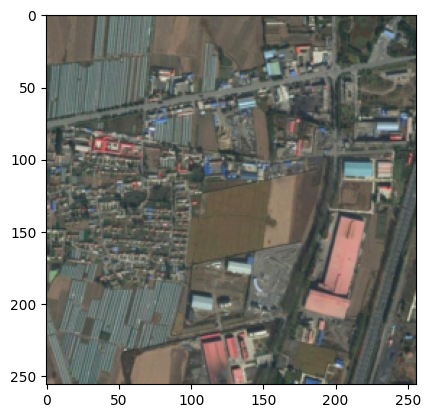

In [19]:
# Get the first image and its corresponding predicted and target boxes
image,_ = test_dataset[0]

# Plot the image
plt.imshow(image.permute(1, 2, 0))

# Plot the predicted boxes
for box in pred_boxes[0]:
    class_label = box
    x, y = box[1:3]  # Update to only use x and y coordinates
    plt.scatter(x, y, color='r')
    plt.text(x, y, f'{class_label}', color='r')

# Plot the target boxes
for box in target_boxes[0]:
    class_label = box[0]
    x, y = box[1:3]  # Update to only use x and y coordinates
    plt.scatter(x, y, color='g')
    plt.text(x, y, f'{class_label}', color='g')

# Show the plot
plt.show()

In [ ]:
# sample = torch.rand(1, 3, 256, 256)
# model.eval()
# output = model(sample)
# print(output.shape)

In [ ]:

# # Set the path to save the ONNX model
# onnx_model_path = "model.onnx"

# # Export the model to ONNX format
# torch.onnx.export(model, sample, onnx_model_path)


# PYHELAYERS

## Select a subset of plain samples from test set

In [ ]:
# test_img_list=[]
# test_label_list=[]
# for image,label in test_dataset:
#     test_img_list.append(image)
#     test_label_list.append(label)
#     if len(test_img_list)==1:
#         break

# test_img_array = np.array(test_img_list)
# test_label_array = np.array(test_label_list)
# # test_img_array = test_img_array[:11728]
# # test_label_array = test_label_array[:11728]
# # test_img_array = test_img_array.reshape(733,16,3,64,64)
# # test_label_array = test_label_array.reshape(733,16,7,7,30)
# print(test_img_array.shape)
# print(test_label_array.shape)

## Initialize he scheme

In [ ]:
# import pyhelayers
# import utils

# utils.verify_memory()

# print('Misc. initalizations')

In [ ]:
# context = pyhelayers.DefaultContext()
# print('HE context ready')

In [ ]:

# nnp = pyhelayers.NeuralNetPlain()

In [ ]:
# hyper_params = pyhelayers.PlainModelHyperParams()
# nnp.init_from_files(hyper_params, ["model.onnx"])


In [ ]:
# he_run_req = pyhelayers.HeRunRequirements()
# he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
# he_run_req.optimize_for_batch_size(1)

# profile = pyhelayers.HeModel.compile(nnp, he_run_req)
# batch_size = profile.get_optimal_batch_size()
# print('Profile ready. Batch size=',batch_size)

In [ ]:
# profile.get_he_config_requirement()

In [ ]:
# context = pyhelayers.HeModel.create_context(profile)
# print('HE context initalized')

In [ ]:
# context.get_scheme_name()

In [ ]:
# context.get_default_scale()

In [ ]:
# context.get_library_name()

In [ ]:
# context.has_secret_key()

In [ ]:
# context.save_secret_key_to_file('secret_key.txt')

In [ ]:
# nn = pyhelayers.NeuralNet(context)
# nn.encode_encrypt(nnp, profile)
# print('Encrypted network ready')

In [ ]:
# plain_samples, labels = utils.extract_batch(test_img_array, test_label_array, batch_size, 0)

# print('Batch of size',batch_size,'loaded')

In [ ]:
# print(plain_samples.shape)
# print(plain_samples.dtype)

In [ ]:
# iop = nn.create_io_processor()
# samples = pyhelayers.EncryptedData(context)
# iop.encode_encrypt_inputs_for_predict(samples, [plain_samples])
# print('Test data encrypted')

## Make prediction on encrypted data

In [ ]:
# utils.start_timer()

# predictions = pyhelayers.EncryptedData(context)
# nn.predict(predictions, samples)

# duration=utils.end_timer('predict')
# utils.report_duration('predict per sample',duration/batch_size)

In [ ]:
# plain_predictions_aHE = iop.decrypt_decode_output(predictions)
# print(f"plain prediction shape after HE: {plain_predictions_aHE.shape}")

In [ ]:
# type(plain_predictions_aHE)

In [ ]:
# ## In case I have test samples > batch size
# plain_predictions_aHE = plain_predictions_aHE.reshape(,1470)

## Evaluate prediction with HE

In [ ]:
# plain_predictions_bHE=[]
# for sample in test_img_array:
#     tensor_sample = torch.tensor(sample).unsqueeze(0)
#     output = model(tensor_sample)
#     output = output.detach().numpy()
#     plain_predictions_bHE.append(output)
# plain_predictions_bHE = np.array(plain_predictions_bHE)
# plain_predictions_bHE = plain_predictions_bHE.reshape(16, 1470)
# print(f"plain prediction shape before HE: {plain_predictions_bHE.shape}")


In [ ]:

# # Compute the absolute differences between plain prediction before and after HE
# differences = np.abs(plain_predictions_bHE - plain_predictions_aHE)

# # Compute relevant statistics
# mean_difference = np.mean(differences)
# max_difference = np.max(differences)
# min_difference = np.min(differences)
# std_difference = np.std(differences)

# print(f"Mean difference: {mean_difference}")
# print(f"Max difference: {max_difference}")
# print(f"Min difference: {min_difference}")
# print(f"Std difference: {std_difference}")


### Convert prediction in bounding boxes

In [ ]:
# def get_bboxes_from_prediction(
#     predictions,
#     test_image_array,
#     iou_threshold,
#     threshold,
# ):
#     all_pred_boxes = []

    
#     train_idx = 0

#     bboxes = cellboxes_to_boxes(predictions)

#     for idx in range(len(test_image_array)):
#         image = test_image_array[idx]

#         nms_boxes = non_max_suppression(
#             bboxes[idx],
#             iou_threshold=iou_threshold,
#             threshold=threshold,
#         )

#         # Activate only for test
#         if  idx == 0:
#             plot_image(image.permute(1,2,0).to("cpu"), nms_boxes)

#         for nms_box in nms_boxes:
#             all_pred_boxes.append([train_idx] + nms_box)

        

#         train_idx += 1

#     return all_pred_boxes


In [ ]:
# tensor_predaHE = torch.tensor(plain_predictions_aHE)
# tensor_predbHE = torch.tensor(plain_predictions_bHE)
# tensor_imgs = torch.tensor(test_img_array)

# print("Prediction before HE")
# bboxes_aHE = get_bboxes_from_prediction(tensor_predbHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)

# print("Prediction after HE")
# bboxes_bHE = get_bboxes_from_prediction(tensor_predaHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)